In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot
sns.set()
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD
import pandas as pd
import keras
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tensorflow.python import debug as tf_debug
from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

Using TensorFlow backend.


In [2]:
df1 = pd.read_csv('train.csv')
df2 = pd.read_csv('test.csv')


def drop_columns(df, columns):
    df.drop(columns, axis=1,inplace=True)
    return df

def fill_NA(df, columns, value):
    for c in columns:
        df[c].fillna(value,inplace=True)
    return df

def get_dummies_for_category_columns(df, columns):
    df = pd.concat([df,pd.get_dummies(df[columns])],axis=1)
    df.drop(columns, axis=1, inplace=True)
    return df

def drop_huge_buildings(df):
    # Drop huge buildings
    df=df[df["1stFlrSF"]<4000]
    df=df[df["LotArea"]<50000]
    df=df[df["BsmtFullBath"]<3] # why would you even have 3 bath in the basement?
    return df

def set_type(df, column, type_name):
    df[column] = df[column].astype(type_name)
    return df

def drop_non_correlated_columns(df, min_corr):
    salesPriceCorr = df.corr()['SalePrice']
    good_corr = np.logical_or(salesPriceCorr<-min_corr, salesPriceCorr>min_corr)
    onlyCorrelatedColumns = salesPriceCorr[good_corr]
    df = df[onlyCorrelatedColumns.index]
    return df

def log_tranform(df, columns):
    for c in columns:
        df['log_'+c] = np.log1p(df[c])       
    return drop_columns(df, columns)

def year_to_age(df, column):
    df['age_'+column] = 2019 - df[column]
    return drop_columns(df, column)

def create_exists_column(df, column):
    df['exists_'+ column] = df[column] > 0
    return df;
    

In [3]:

#sns.pairplot(df1,y_vars=["SalePrice"], x_vars=df1.columns, hue="SaleCondition")

In [4]:
# high NAN count
high_nan_columns = ['Electrical','LotFrontage','GarageYrBlt']
no_variety_columns = ['Utilities','Condition2','Heating','PavedDrive','Street','BsmtCond','GarageFinish','GarageFinish','RoofMatl']
columnsToFillNone= ['GarageCond','BsmtQual', 'FireplaceQu', 'MiscFeature','PoolQC','Alley','Fence','MasVnrType','GarageQual', 'GarageType','BsmtFinType2','BsmtFinType1','BsmtExposure']
columnsToFillZero= ['MasVnrArea',"BsmtFinSF1","BsmtFinSF2",'BsmtUnfSF',"TotalBsmtSF","BsmtFullBath","BsmtHalfBath","GarageCars","GarageArea" ] 
ignoreUncorrelatedRate = 0.00
categoryColumns2 = ["OverallQual","OverallCond","MoSold","BsmtFullBath","FullBath","HalfBath","Fireplaces","GarageCars",'BsmtHalfBath', 'MSSubClass']
areaColumns=[i for i in df1.columns if "SF" in i or 'Area' in i or 'ScreenPorch' in i] 
df1= df1.pipe(drop_huge_buildings)
def preprocess(df):
   return (df.pipe(drop_columns, columns=high_nan_columns) # high number of NA values 
   .pipe(drop_columns, columns=no_variety_columns) # no variety

   .pipe(fill_NA, columns=columnsToFillNone, value='None') # 
   .pipe(fill_NA, columns=columnsToFillZero, value=0) # 
   .pipe(get_dummies_for_category_columns, columns=df.columns[df.dtypes=="object"])
   .pipe(get_dummies_for_category_columns, columns=categoryColumns2)
   .pipe(set_type, 'MasVnrArea','int64')
   .pipe(year_to_age, 'YearBuilt')
   .pipe(year_to_age, 'YearRemodAdd')
   .pipe(year_to_age, 'YrSold')
   .pipe(drop_columns, columns=["Id","BedroomAbvGr"])## drop Garbage
   .pipe(log_tranform, columns=areaColumns)       
)

df1 = preprocess(df1).pipe(drop_non_correlated_columns, min_corr=ignoreUncorrelatedRate) 
df2_ids=df2['Id']
df2 = preprocess(df2)
df1.describe()

,KitchenAbvGr,TotRmsAbvGrd,EnclosedPorch,3SsnPorch,MiscVal,SalePrice,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Alley_Grvl,Alley_None,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_None,BsmtQual_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_None,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_None,BsmtFinType2_Rec,BsmtFinType2_Unf,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_None,FireplaceQu_Po,FireplaceQu_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_None,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_None,GarageCond_Po,GarageCond_TA,PoolQC_Ex,PoolQC_Fa,PoolQC_Gd,PoolQC_None,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_None,MiscFeature_Gar2,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,age_YearBuilt,age_YearRemodAdd,age_YrSold,log_LotArea,log_MasVnrArea,log_BsmtFinSF1,log_BsmtFinSF2,log_BsmtUnfSF,log_TotalBsmtSF,log_1stFlrSF,log_2ndFlrSF,log_LowQualFinSF,log_GrLivArea,log_GarageArea,log_WoodDeckSF,log_OpenPorchSF,log_ScreenPorch,

In [5]:
#df1.hist(figsize=(40,40))

In [6]:
corr=df1.corr()
mask = np.zeros_like(corr, dtype=np.bool)
#mask[np.triu_indices_from(mask)] = True

In [7]:
#f, ax = plt.subplots(figsize=(20, 20))
#cmap = sns.diverging_palette(220, 10, as_cmap=True)
#sns.heatmap(corr, cmap=cmap, vmax=1, center=0, xticklabels=True, yticklabels=True,
#            linewidths=.5, cbar_kws={"shrink": 1})

In [8]:
#sns.pairplot(df1,y_vars=["SalePrice"], x_vars=df1.columns)


In [9]:
y = df1['SalePrice']
# X = df[['LotArea']]

X = df1.drop('SalePrice', axis=1)


In [10]:

# define model
model = Sequential()
input_layer = Dense(256, input_dim=len(X.columns), activation='relu', kernel_initializer='normal') 
model.add(input_layer)
model.add( Dense(256, activation='relu', kernel_initializer='normal') )
model.add( Dense(256, activation='relu', kernel_initializer='normal') )
model.add( Dense(256, activation='relu', kernel_initializer='normal') )
model.add(Dense(1, activation='linear'))

optimizer = keras.optimizers.Adam() #Adam(lr=0.0015);
# compile model
model.compile(loss='mean_squared_logarithmic_error', optimizer=optimizer)

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Use tf.cast instead.
Restoring model weights from the end of the best epoch
Epoch 00092: early stopping
Train: 0.021, Test: 0.026


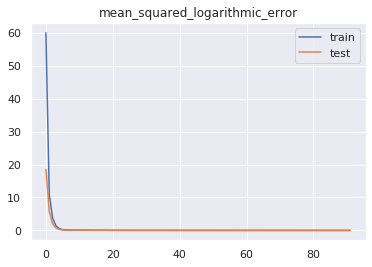

In [11]:


trainX, testX, trainy, testy = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=1)
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaler.fit(trainX)
trainX= scaler.transform(trainX)
testX= scaler.transform(testX)
# fit model
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=30, verbose=1, mode='auto', baseline=None, restore_best_weights=True)
tb_callback =keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=32, write_graph=True, write_grads=True, write_images=True, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None, update_freq='epoch')
history = model.fit(trainX, trainy, validation_data=(testX, testy), 
                    epochs=3000, verbose=0, batch_size=32, callbacks=[early_stop, tb_callback])
# evaluate the model
train_mse = model.evaluate(trainX, trainy, verbose=0)
test_mse = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))
# plot loss during training
pyplot.title('mean_squared_logarithmic_error')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
# pyplot.plot(history.history['acc'], label='train_acc')
# pyplot.plot(history.history['val_acc'], label='test_acc')
pyplot.legend()
pyplot.show()

In [12]:
print(input_layer.get_weights())


[array([[ 0.01022913,  0.02887375,  0.04544323, ...,  0.03416737,
         0.00171663,  0.05904537],
       [-0.001663  ,  0.12798531,  0.02634136, ...,  0.07291158,
         0.06292236,  0.00354264],
       [ 0.03325377, -0.01022596, -0.02374018, ...,  0.0480148 ,
         0.06778474,  0.02455694],
       ...,
       [ 0.02313915,  0.11574699,  0.16540962, ...,  0.0509031 ,
         0.07753657,  0.04350779],
       [ 0.0589981 ,  0.0928878 ,  0.11796578, ...,  0.0176266 ,
         0.06781118,  0.09148282],
       [ 0.05014912,  0.10484181,  0.08035242, ...,  0.10210425,
         0.07476747,  0.09361241]], dtype=float32), array([ 0.04014767,  0.08161875,  0.05960722, -0.00492705,  0.01540467,
        0.03448551,  0.0446614 ,  0.05285585, -0.00924293,  0.04668676,
        0.08040822,  0.07229516,  0.04179642,  0.05005069, -0.00874333,
       -0.01396118,  0.11663846, -0.01266718,  0.03987815,  0.06385713,
        0.0702    , -0.00606123,  0.06009187,  0.04202969,  0.06756882,
        0.

In [13]:
df2.describe()

,KitchenAbvGr,TotRmsAbvGrd,EnclosedPorch,3SsnPorch,MiscVal,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Alley_Grvl,Alley_None,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_None,BsmtQual_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_None,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_None,BsmtFinType2_Rec,BsmtFinType2_Unf,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_None,FireplaceQu_Po,FireplaceQu_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,GarageQual_Fa,GarageQual_Gd,GarageQual_None,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_None,GarageCond_Po,GarageCond_TA,PoolQC_Ex,PoolQC_Gd,PoolQC_None,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_None,MiscFeature_Gar2,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,age_YearBuilt,age_YearRemodAdd,age_YrSold,log_LotArea,log_MasVnrArea,log_BsmtFinSF1,log_BsmtFinSF2,log_BsmtUnfSF,log_TotalBsmtSF,log_1stFlrSF,log_2ndFlrSF,log_LowQualFinSF,log_GrLivArea,log_GarageArea,log_WoodDeckSF,log_OpenPorchSF,log_ScreenPorch,log_PoolArea
count,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.00000,1459.000000,1459.000000

In [14]:
dfX=scaler.transform(df2[X.columns])

KeyError: "['HouseStyle_2.5Fin', 'Exterior1st_ImStucc', 'PoolQC_Fa', 'Exterior1st_Stone', 'MiscFeature_TenC', 'GarageQual_Ex', 'Exterior2nd_Other'] not in index"

In [ ]:
result = model.predict(dfX)

In [ ]:
dfR = pd.DataFrame(df2_ids)
dfR['SalePrice']=result

In [ ]:
dfR.describe()

In [ ]:
dfR.head()

In [ ]:
dfR.to_csv('predictions.csv',index = None, header=True)

In [ ]:
df5 = pd.read_csv('test.csv')



In [ ]:
predicted = model.predict(X)

In [ ]:
df1['PredictedPrice']=predicted
df1['Delta'] = df1['SalePrice']-df1['PredictedPrice']


In [ ]:
corr=df1.corr()['Delta']
corr=corr[np.abs(corr)>0.35] 
corr=corr.drop(['Delta', 'PredictedPrice'])
print(corr.index)
plt.scatter( corr,corr.index)
# f, ax = plt.subplots(figsize=(40, 40))
# cmap = sns.diverging_palette(220, 10, as_cmap=True)
# sns.heatmap(corr, cmap=cmap, vmax=1, center=0, xticklabels=True, yticklabels=True,
#             linewidths=.5, cbar_kws={"shrink": 1})

In [ ]:
w = input_layer.get_weights()

In [ ]:
w[1]

In [ ]:
len(w[0])

In [ ]:
weights = pd.DataFrame(w[0])
weights.insert(loc=0, column='feature', value=X.columns)
weights.set_index('feature', inplace=True)
                     


In [ ]:
weights.columns

In [ ]:
 wt = weights.transpose()

In [ ]:
wt.describe()